- The main moto to create this kernel is to practice RNNs. RNNs have truly changed the way sequential data is forecasted. I wanted to create the sample reference for RNNs.
- Please upvote the kernel if you like it

# Recurrent Neural Networks
- In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself à la Elman) rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.
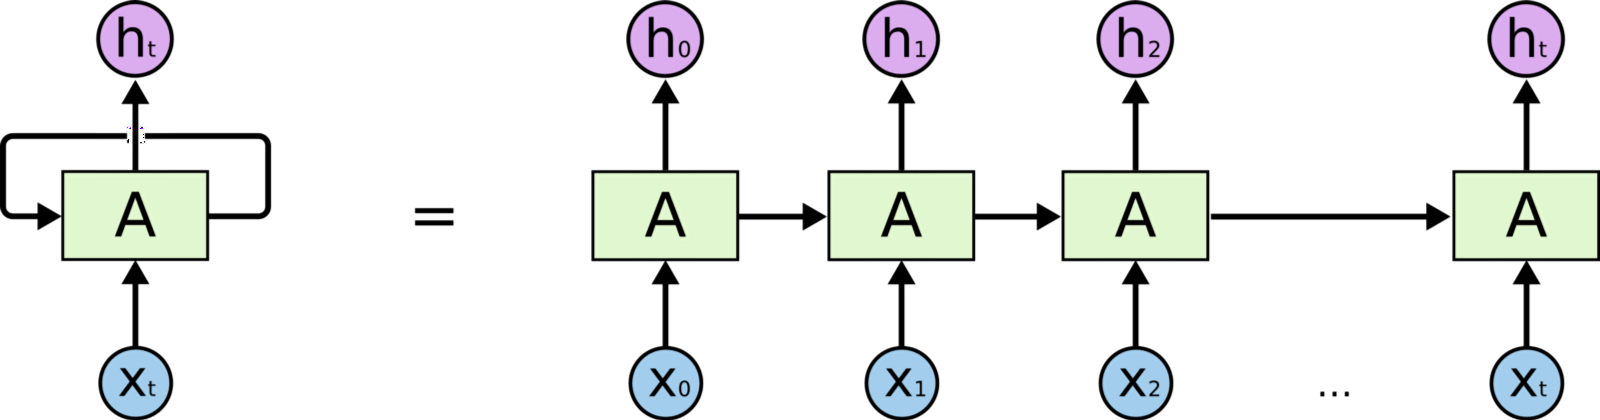
- RNNs are quite powerful, they suffer from Vanishing gradient problem which hinders them from using long term information, like they are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results so we don't just use regular RNNs. Instead, we use a better variation of RNNs: Long Short Term Networks(LSTM).

# What is Vanishing Gradient problem?
* Neural networks are trained using stochastic gradient descent.
* This involves first calculating the prediction error made by the model and using the error to estimate a gradient used to update each weight in the network so that less error is made next time. This error gradient is propagated backward through the network from the output layer to the input layer.
* It is desirable to train neural networks with many layers, as the addition of more layers increases the capacity of the network, making it capable of learning a large training dataset and efficiently representing more complex mapping functions from inputs to outputs.
* A problem with training networks with many layers (e.g. deep neural networks) is that the gradient diminishes dramatically as it is propagated backward through the network. The error may be so small by the time it reaches layers close to the input of the model that it may have very little effect. As such, this problem is referred to as the “vanishing gradients” problem.
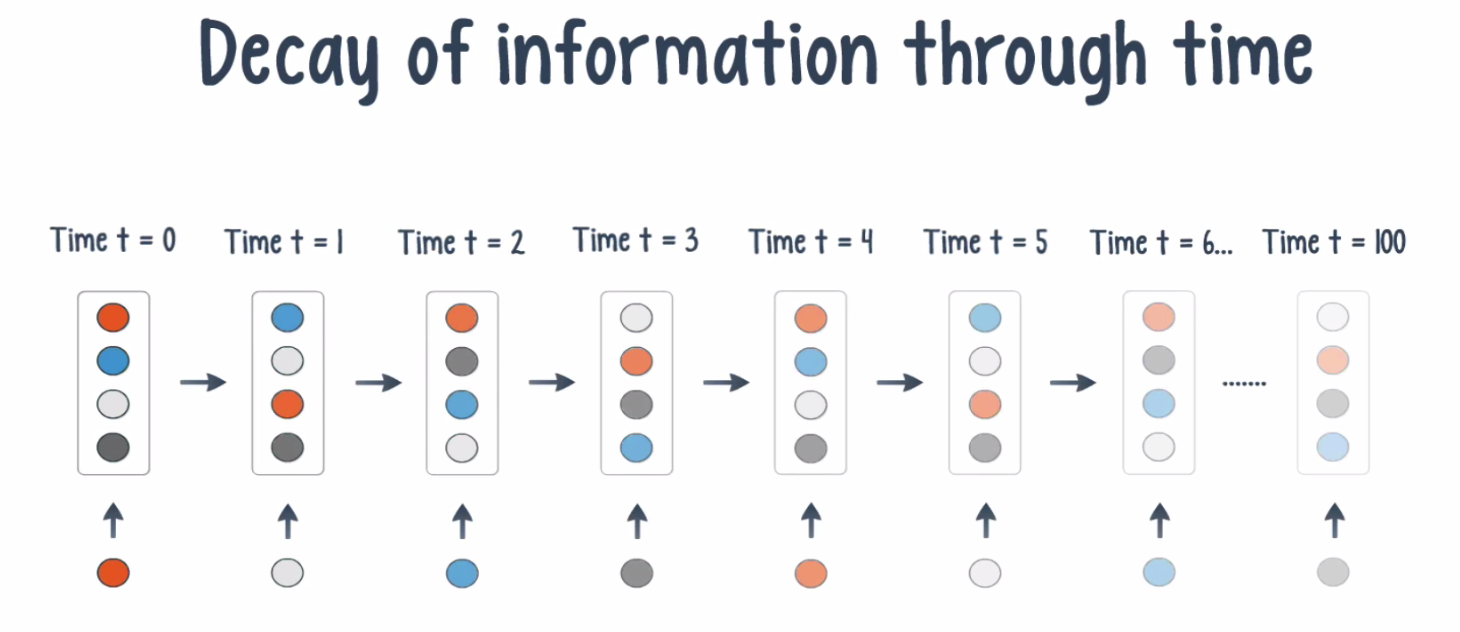

# What Are Exploding Gradients?
1. An error gradient is the direction and magnitude calculated during the training of a neural network that is used to update the network weights in the right direction and by the right amount.
1. In deep networks or recurrent neural networks, error gradients can accumulate during an update and result in very large gradients. These in turn result in large updates to the network weights, and in turn, an unstable network. At an extreme, the values of weights can become so large as to overflow and result in NaN values.
1. The explosion occurs through exponential growth by repeatedly multiplying gradients through the network layers that have values larger than 1.0.

For the vanishing gradient problem, many approaches have been suggested, below are few of them:
1. Using ReLU activation function.
1. Long-Short Term Memory (LSTM) architecture, where the forget gate might help.
1. Initialize the weight matrix, W, with an orthogonal matrix, and use this through the entire training (multiplications of orthogonal matrices doesn’t explode or vanish).

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate,GRU,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import FixedLenFeature
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, normalize

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

In [ ]:
try: 
     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
     strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

In [ ]:

AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
train_df = pd.read_csv('../input/higgs-boson/training.zip')
test_df = pd.read_csv('../input/higgs-boson/test.zip')

print(train_df.shape,test_df.shape)

# Check for the missing column in test dataset
- the Label which is target column and weight is missing from the test dataset
- So let's drop the Weight column from the training datset

In [ ]:
list(set(train_df.columns ) - set(test_df.columns))

In [ ]:
train_df.drop(['Weight'], axis=1,inplace=True)

# Target Variable count
- We can clearly says the dataset is imbalanced and it has more labels of b
- Label b in training data are doluble in number of Label S

In [ ]:
sns.barplot(x = train_df['Label'].value_counts().index, y = train_df['Label'].value_counts().values)
plt.title('Label counts')
plt.show()

In [ ]:
enc = LabelEncoder()

train_df['Label'] = enc.fit_transform(train_df['Label'])
train_df.head()

In [ ]:
train_df.set_index(['EventId'],inplace = True)
test_df.set_index(['EventId'],inplace = True)

In [ ]:
X = train_df.drop(['Label'], axis=1)
y = train_df['Label'].values

# Scaling the datset

In [ ]:
X = normalize(X)
test_df_nor = normalize(test_df)

# StratifiedShuffleSplit
- This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
- As we are having class imbalance over here hence it is better to go with stratified split to preserve the same class ratio.

In [ ]:
splitter=StratifiedShuffleSplit(n_splits=1,random_state=12)

for train,test in splitter.split(X,y):     #this will splits the index
    X_train_SS = X[train]
    y_train_SS = y[train]
    X_test_SS = X[test]
    y_test_SS = y[test]

In [ ]:
# reshape for rnn
X_train_SS = np.reshape(X_train_SS, (X_train_SS.shape[0],X_train_SS.shape[1],1))
X_test_SS = np.reshape(X_test_SS, (X_test_SS.shape[0],X_test_SS.shape[1],1))

In [ ]:
X_train_SS.shape[2]

# Long Short Term Memory(LSTM)
* Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

* The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: Wikipedia
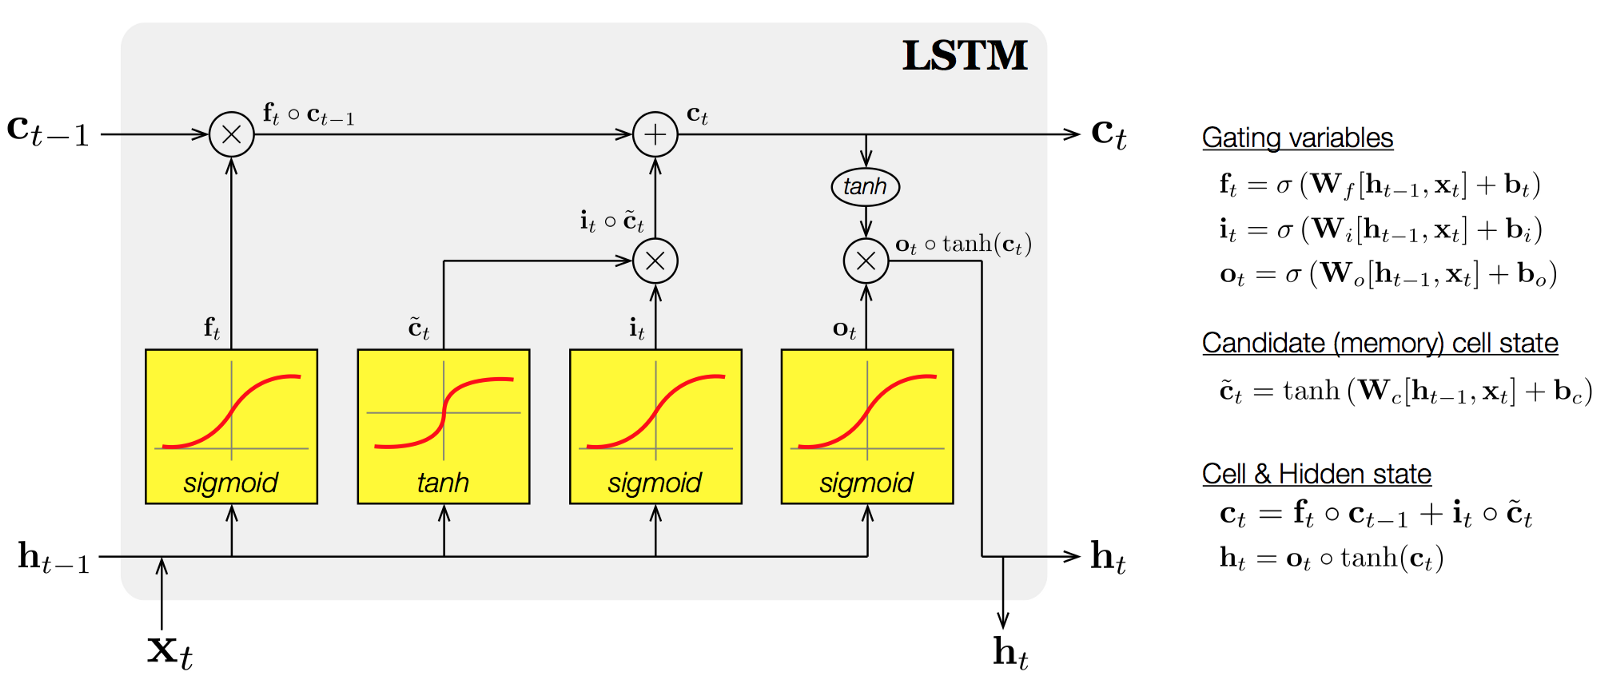

# Components of LSTMs
So the LSTM cell contains the following components

* Forget Gate “f” ( a neural network with sigmoid)
* Candidate layer “C"(a NN with Tanh)
* Input Gate “I” ( a NN with sigmoid )
* Output Gate “O”( a NN with sigmoid)
* Hidden state “H” ( a vector )
* Memory state “C” ( a vector)
* Inputs to the LSTM cell at any step are Xt (current input) , Ht-1 (previous hidden state ) and Ct-1 (previous memory state).
* Outputs from the LSTM cell are Ht (current hidden state ) and Ct (current memory state)

# Working of gates in LSTMs
First, LSTM cell takes the previous memory state Ct-1 and does element wise multiplication with forget gate (f) to decide if present memory state Ct. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

**Ct = Ct-1 * ft**

Calculating the new memory state:

**Ct = Ct + (It * C`t)**

Now, we calculate the output:

**Ht = tanh(Ct)**

In [ ]:
def build_Lstm_model(train_x,train_y,test_x,test_y):
    inp = Input(shape=(train_x.shape[1],train_x.shape[2]))
    rnn_1st_model = LSTM(units=60, return_sequences=True,recurrent_dropout=0.1)(inp)
    rnn_2nd_model = LSTM(units=60,recurrent_dropout=0.1)(rnn_1st_model)
    dense_layer = Dense(128)(rnn_2nd_model)
    drop_out = Dropout(0.2)(dense_layer)
    output = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(drop_out)
    model = Model(inp, output)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_LSTM.h5', monitor='val_loss', save_best_only=True)]
    model.summary()
    model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),
                        tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")
    history = model.fit(train_x, train_y, 
          epochs = 20, 
          batch_size = 128, 
          validation_data=(test_x,  test_y), 
          callbacks=callbacks)
    return history,model

# Gated Recurrent Units
* GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly
* In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

* They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.
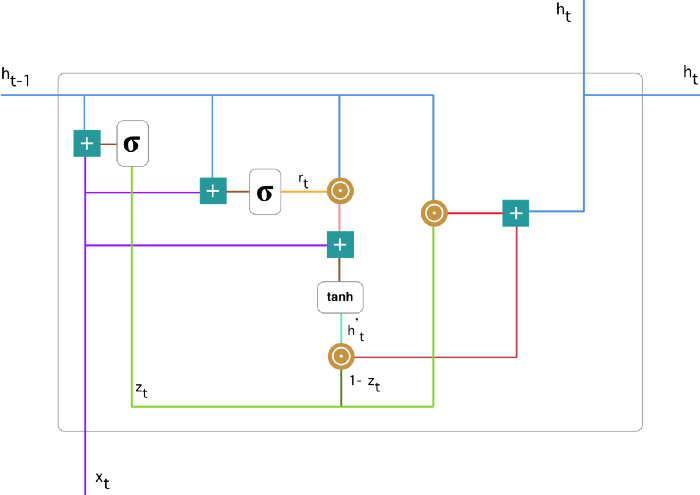

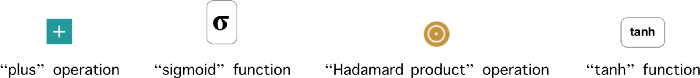

* Update gate: The update gate helps the model to determine how much of the past information (from     previous time steps) needs to be passed along to the future.We start with calculating the update  gate z_t for time step t using the formula:
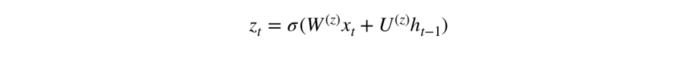

* Reset gate
- Essentially, this gate is used from the model to decide how much of the past information to forget. To calculate it, we use:
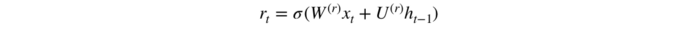

* Current memory content
-  First, we start with the usage of the reset gate. We introduce a new memory content which will use the reset gate to store the relevant information from the past. It is calculated as follows:
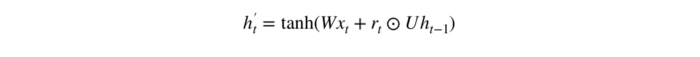
- Multiply the input x_t with a weight W and h_(t-1) with a weight U.
- Calculate the Hadamard (element-wise) product between the reset gate r_t and Uh_(t-1). That will determine what to remove from the previous time steps
- Sum up the results of above steps
- Apply the nonlinear activation function tanh.

* Final memory at current time step
- As the last step, the network needs to calculate h_t — vector which holds information for the current unit and passes it down to the network.
- In order to do that the update gate is needed. It determines what to collect from the current memory content — h’_t and what from the previous steps — h_(t-1). That is done as follows:
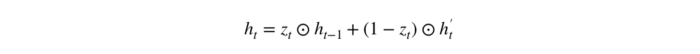

In [ ]:
def build_Gru_model(train_x,train_y,test_x,test_y):
    inp = Input(shape=(train_x.shape[1],train_x.shape[2]))
    rnn_1st_model = GRU(units=60, return_sequences=True,recurrent_dropout=0.1)(inp)
    rnn_2nd_model = GRU(units=60,recurrent_dropout=0.1)(rnn_1st_model)
    dense_layer = Dense(128)(rnn_2nd_model)
    drop_out = Dropout(0.25)(dense_layer)
    output = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(drop_out)
    model = Model(inp, output)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_GRU.h5', monitor='val_loss', save_best_only=True)]
    model.summary()
    model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),
                        tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")
    history = model.fit(train_x, train_y, 
          epochs = 20, 
          batch_size = 128, 
          validation_data=(test_x,  test_y), 
          callbacks=callbacks)
    return history,model

In [ ]:
def plot_Loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [ ]:

def Save_Result_To_Csv(model,model_name,csv_file):
    test_pre = np.reshape(test_df_nor, (test_df_nor.shape[0],test_df_nor.shape[1],1))
    model.load_weights(model_name)
    prediction = model.predict(test_pre)
    prediction =  np.where(prediction > 0.5, 1, 0)
    prediction = pd.Series(prediction[:,0])
    sub = pd.read_csv('../input/higgs-boson/random_submission.zip')
    test_predict = pd.DataFrame({"EventId":sub['EventId'],"RankOrder":sub['RankOrder'],"Class":prediction})
    test_predict['Class'] = test_predict['Class'].replace(1,'s')
    test_predict['Class'] = test_predict['Class'].replace(0,'b')
    test_predict.to_csv(csv_file,index=False)

In [ ]:
history_LSTM,Lstm_model = build_Lstm_model(X_train_SS,y_train_SS,X_test_SS,y_test_SS)

In [ ]:
plot_Loss(history_LSTM)

In [ ]:
Save_Result_To_Csv(Lstm_model,"best_model_LSTM.h5","submission_LSTM.csv")

In [ ]:
history_GRU,Gru_model = build_Gru_model(X_train_SS,y_train_SS,X_test_SS,y_test_SS)

In [ ]:
plot_Loss(history_GRU)

* Convert the test array to  dimensional shape to predict target vector values

In [ ]:
Save_Result_To_Csv(Gru_model,"best_model_GRU.h5","submission_GRU.csv")

# Conclusion:
- Here we can cleary see that GRU give bette results and it is more faster than LSTM.<br>
- Bidirectional LSTM is also a good way to make the model stronger which is data sets dependant. <br>
- Applying both LSTM and GRU together can also give even better results which would be by next experiment.


# Resources:
* [Intro to Lstm-Gru](https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru)
* [higgs-boson-classification usinfg rnn](https://www.kaggle.com/makhloufsabir/higgs-boson-classification-physics-rnn)
